In [2]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [4]:
os.getcwd()

'/home/ubuntu/nbs'

In [5]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(path): os.mkdir(path)
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [8]:
pd.read_csv(path+'movies.csv').head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [10]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [11]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [12]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [13]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [14]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [15]:
n_factors = 50

In [16]:
np.random.seed = 42

Randomly split into training and validation.

In [17]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [18]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [19]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [20]:
topUsers.head()

userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64

In [21]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [22]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [23]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [24]:
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247


In [25]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [26]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [27]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [31]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80164 samples, validate on 19840 samples
Epoch 1/1
80164/80164 [==============================] - 6s - loss: 9.8403 - val_loss: 3.8107


In [32]:
model.optimizer.lr=0.01

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80164 samples, validate on 19840 samples
Epoch 1/3
80164/80164 [==============================] - 6s - loss: 3.1231 - val_loss: 2.0166
Epoch 2/3
80164/80164 [==============================] - 6s - loss: 2.4049 - val_loss: 1.6448
Epoch 3/3
80164/80164 [==============================] - 6s - loss: 2.2354 - val_loss: 1.5266


In [34]:
model.optimizer.lr=0.001

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80164 samples, validate on 19840 samples
Epoch 1/6
80164/80164 [==============================] - 6s - loss: 2.1732 - val_loss: 1.4689
Epoch 2/6
80164/80164 [==============================] - 6s - loss: 2.1392 - val_loss: 1.4448
Epoch 3/6
80164/80164 [==============================] - 6s - loss: 2.1179 - val_loss: 1.4394
Epoch 4/6
80164/80164 [==============================] - 6s - loss: 2.0984 - val_loss: 1.4439
Epoch 5/6
80164/80164 [==============================] - 6s - loss: 2.0820 - val_loss: 1.4453
Epoch 6/6
80164/80164 [==============================] - 6s - loss: 2.0628 - val_loss: 1.4453


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [28]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [29]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [30]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [31]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [100]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [52]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Exception: Error when checking model target: expected merge_13 to have shape (None, 3) but got array with shape (80164, 1)

In [42]:
model.optimizer.lr=0.01

In [43]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80164 samples, validate on 19840 samples
Epoch 1/6
80164/80164 [==============================] - 6s - loss: 2.5642 - val_loss: 1.6227
Epoch 2/6
80164/80164 [==============================] - 6s - loss: 1.9923 - val_loss: 1.3319
Epoch 3/6
80164/80164 [==============================] - 6s - loss: 1.8365 - val_loss: 1.2206
Epoch 4/6
80164/80164 [==============================] - 6s - loss: 1.7444 - val_loss: 1.1682
Epoch 5/6
80164/80164 [==============================] - 6s - loss: 1.6673 - val_loss: 1.1308
Epoch 6/6
80164/80164 [==============================] - 6s - loss: 1.5950 - val_loss: 1.0984


In [44]:
model.optimizer.lr=0.001

In [45]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80164 samples, validate on 19840 samples
Epoch 1/10
80164/80164 [==============================] - 6s - loss: 1.5243 - val_loss: 1.0732
Epoch 2/10
80164/80164 [==============================] - 6s - loss: 1.4557 - val_loss: 1.0483
Epoch 3/10
80164/80164 [==============================] - 6s - loss: 1.3864 - val_loss: 1.0195
Epoch 4/10
80164/80164 [==============================] - 6s - loss: 1.3186 - val_loss: 0.9977
Epoch 5/10
80164/80164 [==============================] - 6s - loss: 1.2540 - val_loss: 0.9781
Epoch 6/10
80164/80164 [==============================] - 6s - loss: 1.1911 - val_loss: 0.9519
Epoch 7/10
80164/80164 [==============================] - 6s - loss: 1.1325 - val_loss: 0.9328
Epoch 8/10
80164/80164 [==============================] - 6s - loss: 1.0756 - val_loss: 0.9147
Epoch 9/10
80164/80164 [==============================] - 6s - loss: 1.0228 - val_loss: 0.9013
Epoch 10/10
80164/80164 [==============================] - 6s - loss: 0.9730 - val_loss: 0.8841

In [46]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80164 samples, validate on 19840 samples
Epoch 1/5
80164/80164 [==============================] - 6s - loss: 0.9261 - val_loss: 0.8689
Epoch 2/5
80164/80164 [==============================] - 6s - loss: 0.8831 - val_loss: 0.8550
Epoch 3/5
80164/80164 [==============================] - 6s - loss: 0.8425 - val_loss: 0.8432
Epoch 4/5
80164/80164 [==============================] - 6s - loss: 0.8045 - val_loss: 0.8344
Epoch 5/5
80164/80164 [==============================] - 6s - loss: 0.7703 - val_loss: 0.8249


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [47]:
model.save_weights(model_path+'bias.h5')

In [59]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [60]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.1636]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [61]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [62]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [63]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.58126664, 'Battlefield Earth (2000)'),
 (-0.081956059, 'Super Mario Bros. (1993)'),
 (0.00093169988, 'Police Academy 6: City Under Siege (1989)'),
 (0.0042887097, 'Jaws 3-D (1983)'),
 (0.010902022, 'Wild Wild West (1999)'),
 (0.023584779, 'Blade: Trinity (2004)'),
 (0.040683895, 'Next Karate Kid, The (1994)'),
 (0.041598309, 'Blame It on Rio (1984)'),
 (0.050932337, 'Howard the Duck (1986)'),
 (0.061393678, 'Speed 2: Cruise Control (1997)'),
 (0.063509822, 'Spice World (1997)'),
 (0.063558303, 'Scary Movie 2 (2001)'),
 (0.076052755, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.081739925, 'Blair Witch Project, The (1999)'),
 (0.085120291, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)')]

In [64]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.417592, '3:10 to Yuma (2007)'),
 (1.3431582, 'Blood Simple (1984)'),
 (1.3415427, 'Cyrano de Bergerac (1990)'),
 (1.3375984,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.3346632, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3322825, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3069042, 'The Theory of Everything (2014)'),
 (1.2994986, "Amores Perros (Love's a Bitch) (2000)"),
 (1.2819438, 'Shawshank Redemption, The (1994)'),
 (1.2794827, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.279223, 'Argo (2012)'),
 (1.2550138, 'Smoke (1995)'),
 (1.246139, 'Tom Jones (1963)'),
 (1.2453662, 'How to Train Your Dragon (2010)'),
 (1.2446934, 'Paris, Texas (1984)')]

We can now do the same thing for the embeddings.

In [65]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [69]:
fac0 = movie_pca[0]

In [70]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [71]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.016399026, 'Anaconda (1997)'),
 (0.015152168, 'Police Academy 3: Back in Training (1986)'),
 (0.0082635256, 'Police Academy 6: City Under Siege (1989)'),
 (0.0081463056, 'Grease 2 (1982)'),
 (0.0081297867, 'Gremlins 2: The New Batch (1990)'),
 (0.0079414118, 'Howard the Duck (1986)'),
 (0.0071021938, 'RoboCop 3 (1993)'),
 (0.0068034846, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.0064951465, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.0063150669, 'Godzilla (1998)')]

In [72]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.051229905, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (-0.050311882, 'Usual Suspects, The (1995)'),
 (-0.049773537, 'American Beauty (1999)'),
 (-0.04970051, 'Wallace & Gromit: A Close Shave (1995)'),
 (-0.04877549, 'Sixth Sense, The (1999)'),
 (-0.048363768, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.048338618, 'Monty Python and the Holy Grail (1975)'),
 (-0.048086338, "Schindler's List (1993)"),
 (-0.047475822, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.047420707,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)')]

In [73]:
fac1 = movie_pca[1]

In [74]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [75]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.063091986, 'Annie Hall (1977)'),
 (0.060821563, 'City Lights (1931)'),
 (0.05839714, 'Brokeback Mountain (2005)'),
 (0.054109551, 'Apocalypse Now (1979)'),
 (0.053550359, 'Manhattan (1979)'),
 (0.053529412, 'Clockwork Orange, A (1971)'),
 (0.052936785, 'Big Lebowski, The (1998)'),
 (0.050777189, 'Wild Bunch, The (1969)'),
 (0.050372861, 'Bringing Up Baby (1938)'),
 (0.050178647, 'Paradise Lost: The Child Murders at Robin Hood Hills (1996)')]

In [76]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.098539062, 'Armageddon (1998)'),
 (-0.098272718, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.081238896, 'Stargate (1994)'),
 (-0.075236775, 'Rock, The (1996)'),
 (-0.070282772, 'Ace Ventura: Pet Detective (1994)'),
 (-0.069723703, 'Speed (1994)'),
 (-0.069557704, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.067925677, 'Star Trek IV: The Voyage Home (1986)'),
 (-0.066573948, 'Jurassic Park (1993)'),
 (-0.06624271, 'Outbreak (1995)')]

In [77]:
fac2 = movie_pca[2]

In [78]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [79]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.065520711, 'Tangled (2010)'),
 (0.063266382, 'Double Jeopardy (1999)'),
 (0.062690862, 'Sliding Doors (1998)'),
 (0.060902502, 'Lilo & Stitch (2002)'),
 (0.05871978, '13 Going on 30 (2004)'),
 (0.058664728, 'Room with a View, A (1986)'),
 (0.056959078, "You've Got Mail (1998)"),
 (0.055251792, 'Miss Congeniality (2000)'),
 (0.052118652, 'Last Emperor, The (1987)'),
 (0.051820964, 'Titan A.E. (2000)')]

In [80]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.12588224, 'Silence of the Lambs, The (1991)'),
 (-0.11984995, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.1180434, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.11169725, 'Pulp Fiction (1994)'),
 (-0.091115572, 'Terminator 2: Judgment Day (1991)'),
 (-0.090719722, 'Braveheart (1995)'),
 (-0.08320342, 'Fargo (1996)'),
 (-0.082256891, 'Ace Ventura: Pet Detective (1994)'),
 (-0.081565514, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (-0.078163326, 'Eyes Wide Shut (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [81]:
reload(sys)
sys.setdefaultencoding('utf8')

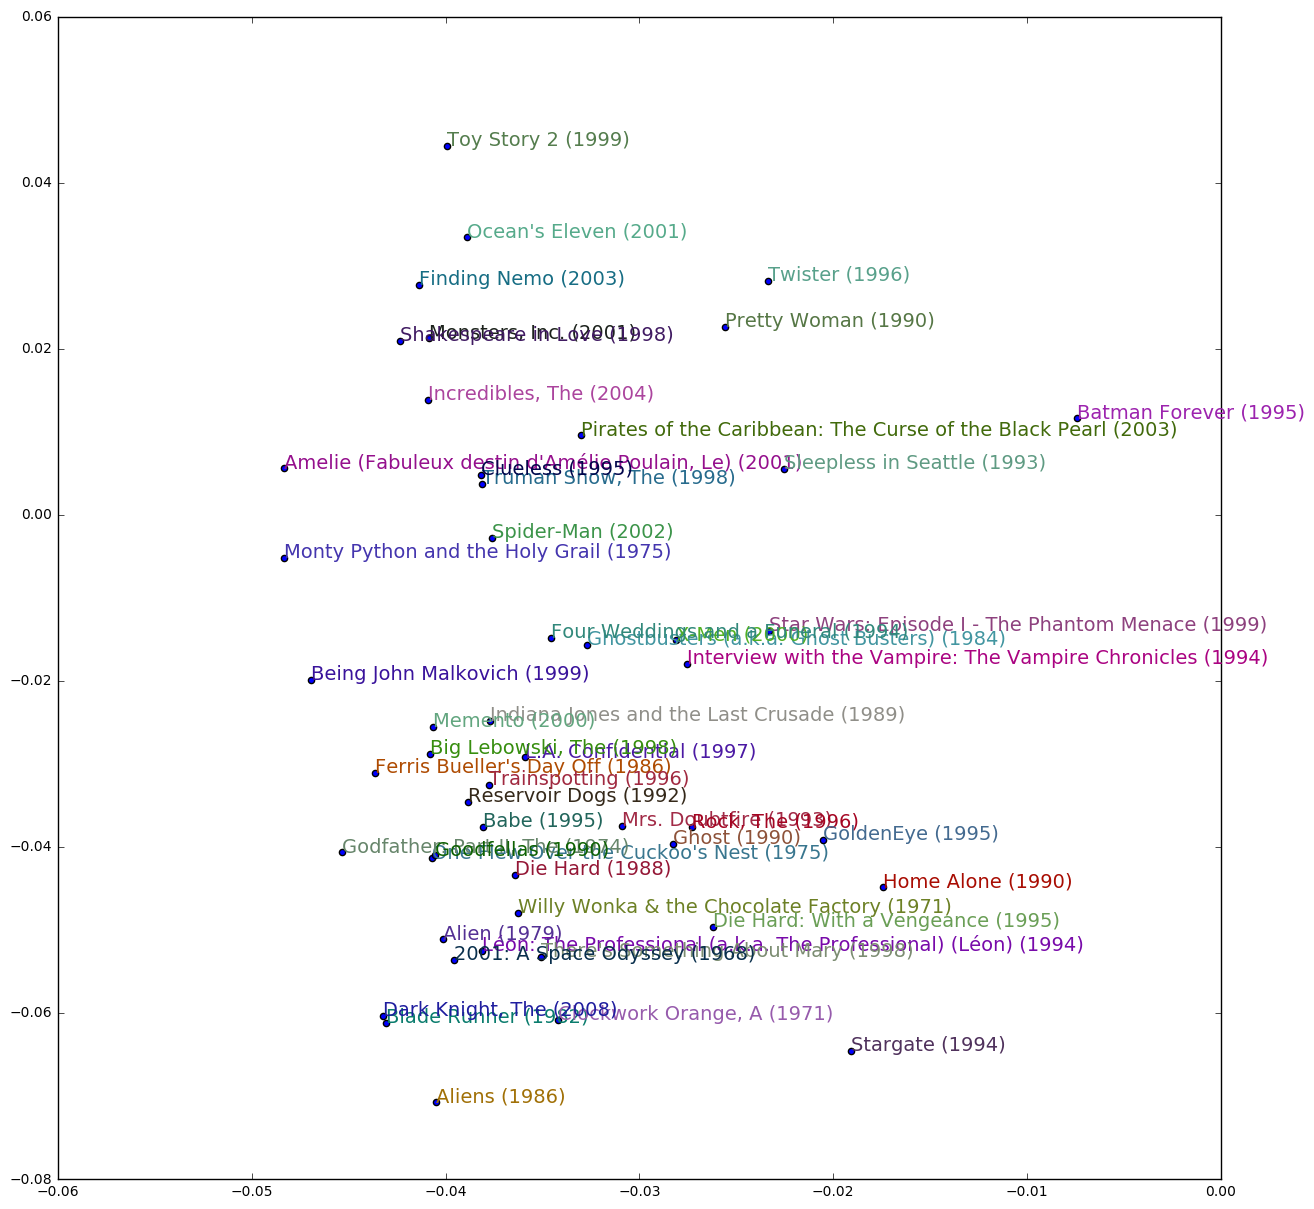

In [82]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [32]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [33]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [34]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/8
80021/80021 [==============================] - 7s - loss: 2.3532 - val_loss: 0.8856
Epoch 2/8
80021/80021 [==============================] - 7s - loss: 1.4133 - val_loss: 0.8705
Epoch 3/8
80021/80021 [==============================] - 7s - loss: 1.2021 - val_loss: 0.8378
Epoch 4/8
80021/80021 [==============================] - 7s - loss: 1.0244 - val_loss: 0.8339
Epoch 5/8
80021/80021 [==============================] - 7s - loss: 0.9100 - val_loss: 0.8183
Epoch 6/8
80021/80021 [==============================] - 7s - loss: 0.8464 - val_loss: 0.8125
Epoch 7/8
80021/80021 [==============================] - 7s - loss: 0.8108 - val_loss: 0.8035
Epoch 8/8
80021/80021 [==============================] - 7s - loss: 0.8024 - val_loss: 0.8075


In [35]:
nn.save_weights(model_path+'nn.h5')

This improves on our already impressive accuracy even further!